The primary goal of the International Consortium for Brain Mapping (ICBM) is to develop a probabilistic reference system for the human brain. The implementation of a data sharing space allows laboratories worldwide to make their own contribution to the ICBM evolving atlas.

# Setup and Libraries

In [11]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and parse Imaging Protocol

In [12]:
CSV_DIR = ROOT_DIR / "csv_dir"
original_df = pd.read_csv(CSV_DIR / "ICBM_all.csv")


# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)
original_df["Study Date"] = pd.to_datetime(original_df["Study Date"], errors="coerce")

print(original_df.columns)
print(len(original_df))

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

# for some reason, some slice thickness are negative
original_df["Slice Thickness"] = original_df["Slice Thickness"].abs()
print(original_df.columns)

Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Handedness', 'Project Phase',
       'Study Date', 'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID', 'Structure', 'Laterality',
       'Registration', 'Tissue'],
      dtype='object')
6605
Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Handedness', 'Project Phase',
       'Study Date', 'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID', 'Structure', 'Laterality',
       'Registration', 'Tissue', 'Acquisition Plane', 'Slice Thickness',
       'Matrix Z', 'Acquisition Type', 'Manufacturer', 'Mfg Model',
       'Field Strength', 'Weighting'],
      dtype='object')


# Filtered dataframe

### Données catégorsiées comme 3D T1, avec Matrix Z > 100 et Slice Thickness < 1.4

In [13]:
# Apply filters
weighting_filter = original_df["Weighting"] == "T1"

df = original_df[
    (original_df["Modality"] == "MRI")
    & weighting_filter
    & (original_df["Matrix Z"] > 100)
    & (original_df["Slice Thickness"] < 1.4)
    & (original_df["Acquisition Type"] == "3D")
    & (original_df["Type"] == "Original")
].copy()

print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)

Filtered dataset size: 1172 images from 496 subjects.


### No filter

In [14]:
# df = original_df

In [15]:
df.head(2)

,Subject ID,Project,Sex,Weight,Handedness,Project Phase,Study Date,Archive Date,Age,Modality,...,Registration,Tissue,Acquisition Plane,Slice Thickness,Matrix Z,Acquisition Type,Manufacturer,Mfg Model,Field Strength,Weighting
0,MNI_0101,ICBM,F,NaN,R,1.0,1995-02-07,1/18/2005,24.0,MRI,...,native,All,SAGITTAL,1.0,256.0,3D,Philips,ACS III,1.5,T1
1,MNI_0102,ICBM,M,NaN,R,1.0,1995-04-11,1/18/2005,29.0,MRI,...,native,All,SAGITTAL,1.0,256.0,3D,Philips,ACS III,1.5,T1


# Basic descriptions

In [16]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]
print(f"Columns with missing values ({len(cols_with_missing)}):\n")

# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Sex
3,Weight
4,Handedness
5,Project Phase
6,Study Date
7,Archive Date
8,Age
9,Modality



=== Numeric Features Summary ===


,Weight,Project Phase,Study Date,Age,Slice Thickness,Matrix Z,Field Strength
count,1021.00,1172.00,1172,1172.00,1172.0,1172.00,1172.00
mean,70.61,1.74,2005-02-02 14:36:02.457337984,37.01,1.0,173.77,1.55
min,44.00,1.00,1995-02-07 00:00:00,18.00,0.8,112.00,0.50
25%,61.20,1.00,1998-12-01 00:00:00,24.00,1.0,160.00,1.50
50%,70.30,2.00,2007-04-20 00:00:00,32.00,1.0,160.00,1.50
75%,77.20,2.00,2008-09-18 00:00:00,50.00,1.0,180.00,1.50
max,137.10,2.00,2009-09-29 00:00:00,80.00,1.3,256.00,3.00
std,13.37,0.44,NaN,15.20,0.1,38.08,0.63



=== Categorical Features Summary ===


,Subject ID,Project,Sex,Handedness,Archive Date,Modality,Description,Type,Imaging Protocol,Image ID,Structure,Laterality,Registration,Tissue,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,1172,1172,1172,1115,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172
unique,496,1,2,3,110,1,15,1,12,1172,1,1,1,1,2,1,3,5,1
top,UTHC_2004,ICBM,F,R,7/06/2006,MRI,SAG MPRAGE 8 CHANNEL,Original,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,3144,Brain,Both,native,All,SAGITTAL,3D,SIEMENS,Sonata,T1
freq,7,1172,601,974,75,1172,692,1172,692,1,1172,1172,1172,1172,1032,1172,869,692,1172



=== Missing Values by Column ===


,Missing Count,Missing %
Weight,151,12.88
Handedness,57,4.86
Project,0,0.00
Subject ID,0,0.00
Sex,0,0.00
Project Phase,0,0.00
Study Date,0,0.00
Archive Date,0,0.00
Age,0,0.00
Modality,0,0.00


Columns with missing values (2):



# Histograms

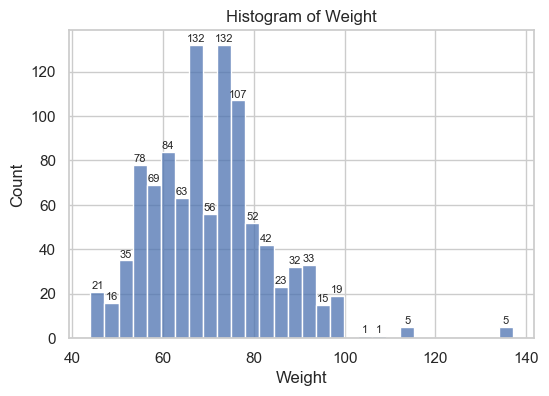

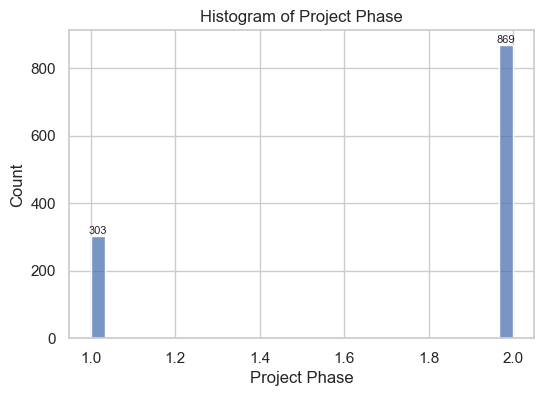

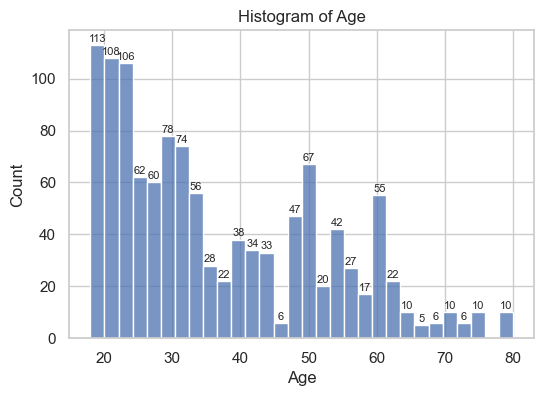

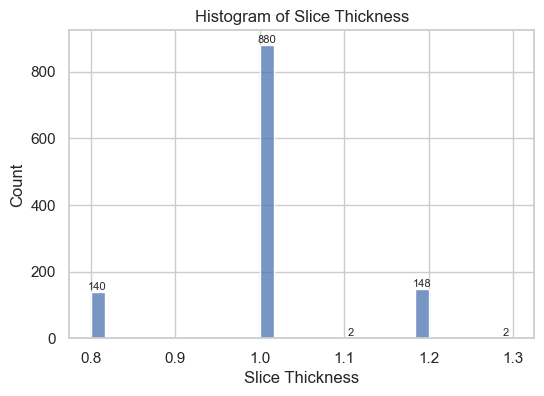

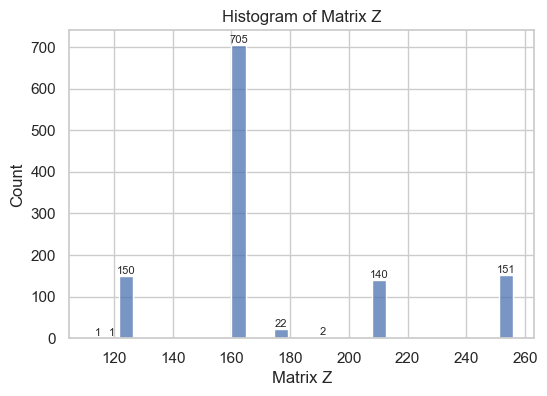

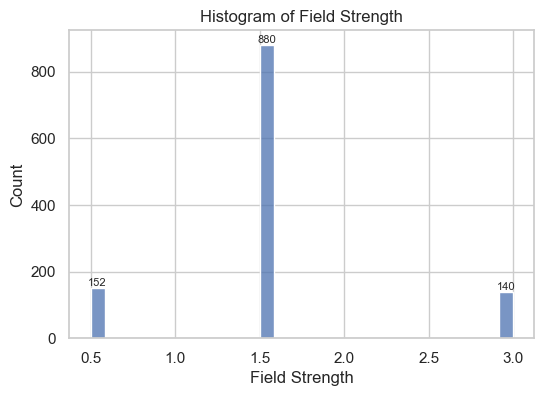

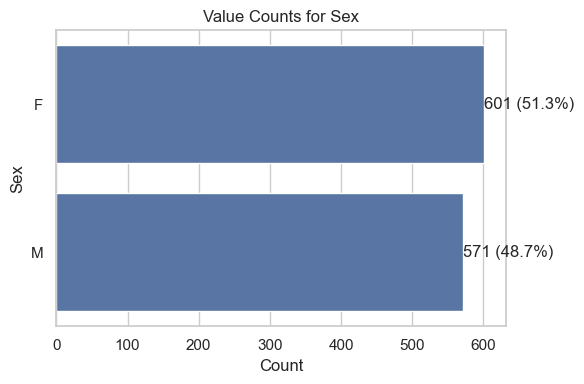

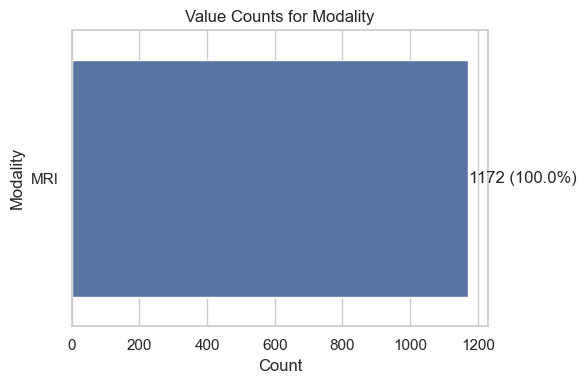

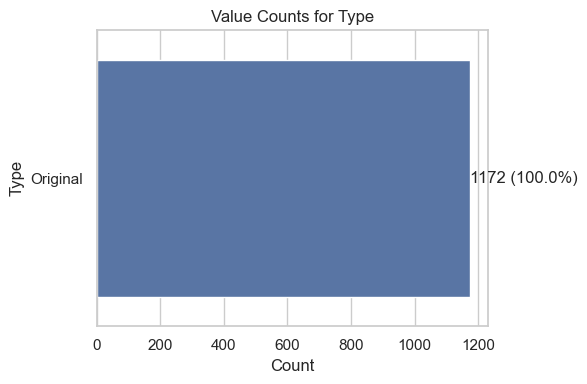

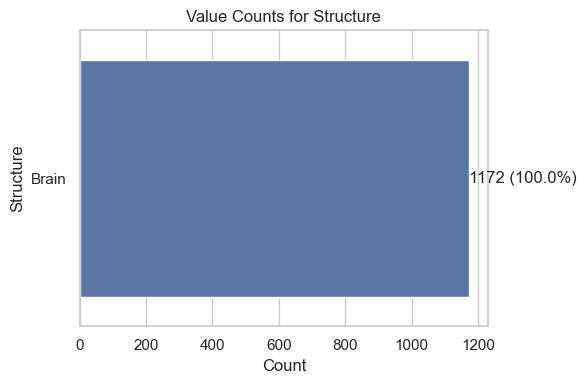

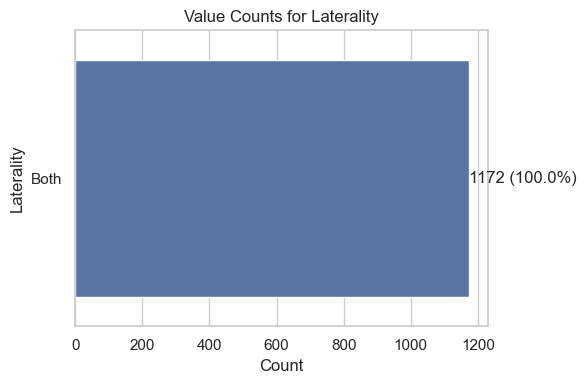

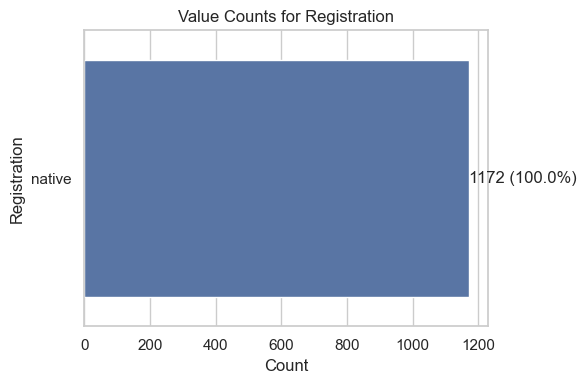

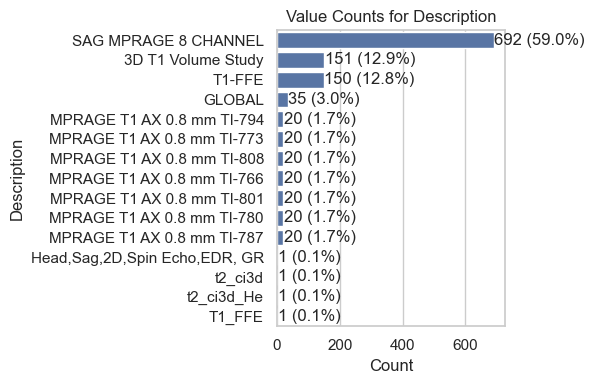

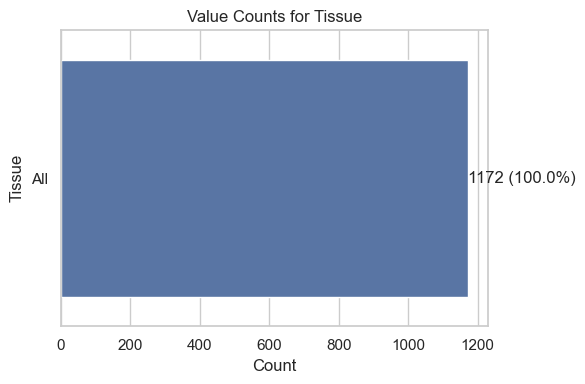

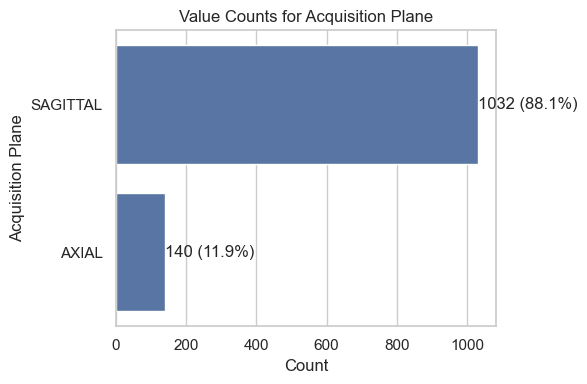

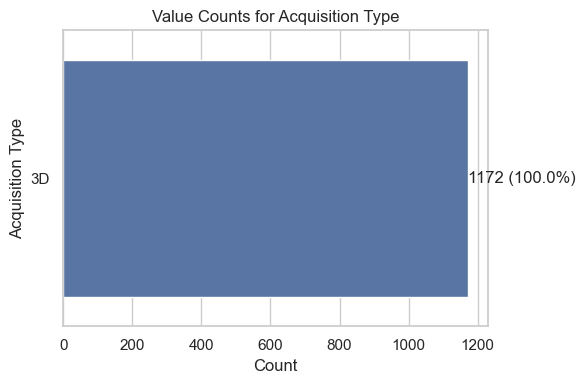

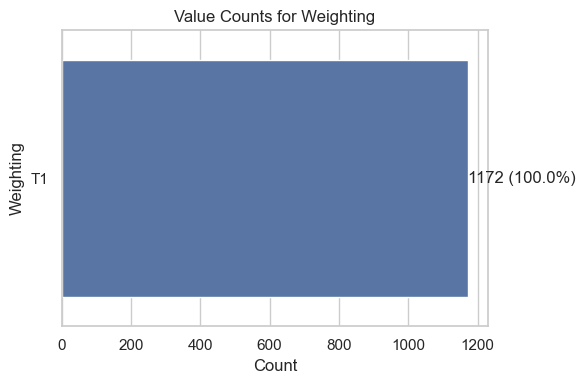

In [17]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram
    ax = sns.histplot(
        df[col].dropna(), bins=30, kde=False
    )  # disable KDE for counts clarity

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Annotate counts on top of each bin
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # only annotate non-empty bins
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # center of bin
                height + 0.5,  # slightly above the bar
                int(height),  # show integer count
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Description",
    "Tissue",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Study dates

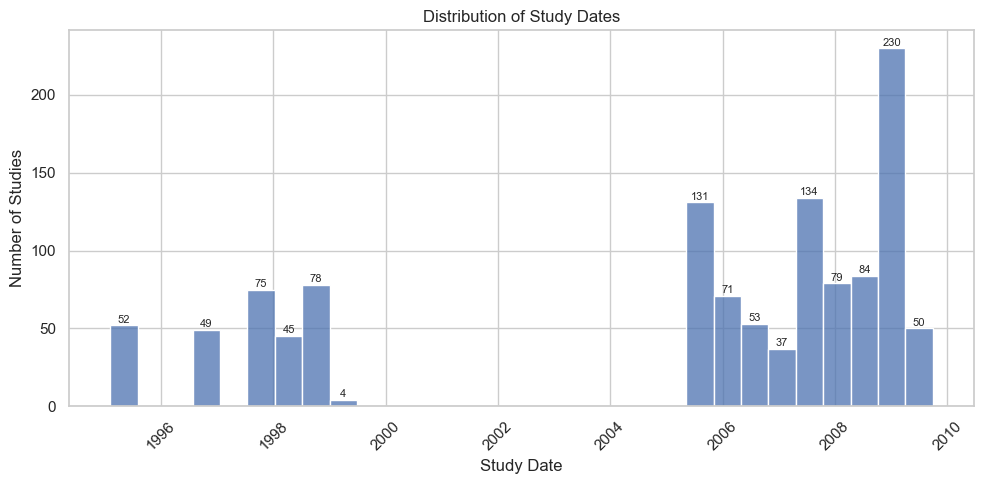

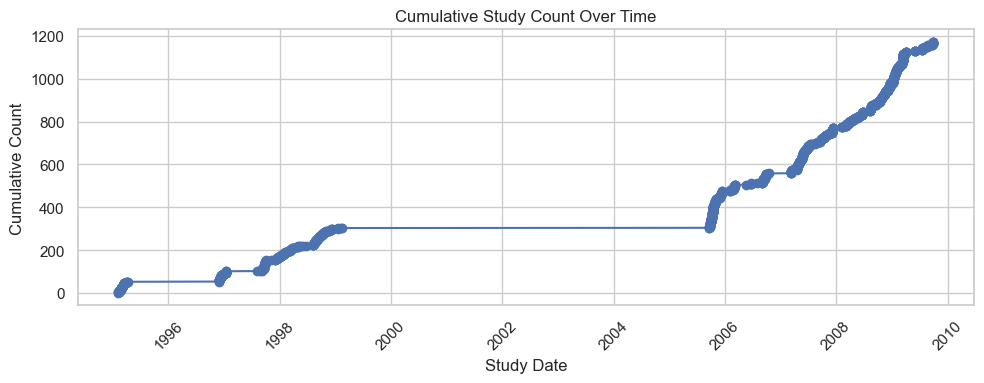

In [18]:
# -------------------------------
# Study Date Distribution
# -------------------------------


plt.figure(figsize=(10, 5))

# Histogram of study dates
ax = sns.histplot(df["Study Date"].dropna(), bins=30, kde=False)

plt.title("Distribution of Study Dates")
plt.xlabel("Study Date")
plt.ylabel("Number of Studies")

# Annotate counts on top of each bin
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# cumulative study count over time
plt.figure(figsize=(10, 4))
df_sorted = df.sort_values("Study Date")
df_sorted["Cumulative Count"] = range(1, len(df_sorted) + 1)
plt.plot(
    df_sorted["Study Date"], df_sorted["Cumulative Count"], marker="o", linestyle="-"
)
plt.title("Cumulative Study Count Over Time")
plt.xlabel("Study Date")
plt.ylabel("Cumulative Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

THERE IS ONLY ONE VISIT PER PATIENT IN ICBM

In [19]:
# scans per subject
scans_per_subject_visit = df.groupby(["Subject ID"]).size().reset_index(name="n_scans")
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()
# print(scans_per_subject_visit.head())
# print(scans_per_subject_visit["n_scans"].min())  # should now be >= 1


/tmp/ipykernel_1168870/4142864101.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scans_per_subject_visit = df.groupby(["Subject ID"]).size().reset_index(name="n_scans")


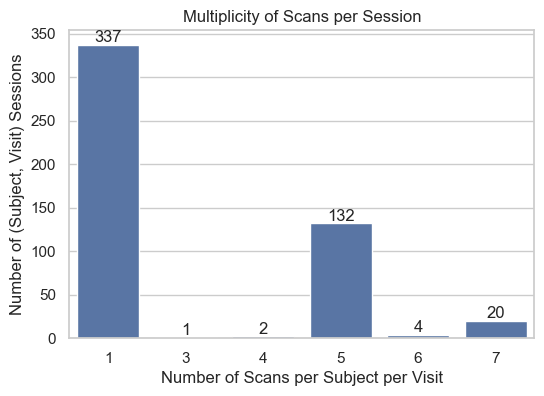

In [20]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()
